Late time kilonova calculations

In [1]:
'''Libraries'''
#Data
import pandas as pd

#Plots
import matplotlib.pyplot as plt

#fits
from scipy.optimize import curve_fit

#math
import numpy as np
from scipy.fft import fft, ifft, fftfreq

#Constants
from scipy.constants import speed_of_light as c
#from scipy.constants import Boltzmann as kb
#from scipy.constants import Stefan_Boltzmann as Sb

#Usefull
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
#%matplotlib widget

In [2]:
'''Abundancias en funcion del tiempo

este codigo carga 554 archivos, cada archivo representa un valor de t en tiempos desde t=2.3E-05 Segundos hasta t=8.64E+06 segundos (100 dias)
 
para cada tiempo hay un archivo de con la siguiente estructura:
    time    temp    dens
   8.64000000000000E+06   1.00000000000000E-02   6.12595382759495E-19
     nin     zin       y       x
  1    0     1.81077137723961E-19   1.81077137723961E-19
  0    1     2.16780459396517E-09   2.16780459396517E-09
  1    1     9.43321881521884E-11   1.88664376304377E-10
  2    1     2.37487509969422E-12   7.12462529908266E-12
  1    2     5.10414497594859E-14   1.53124349278458E-13
  2    2     3.41978236767250E-04   1.36791294706900E-03

nin es el numero de neutrones, zin es el numero de protones, y es number fraction y x es el mass fraction 

La lista Xi_ts es una lista donde cada elemento corresponde a una matriz de 4 columnas (nin,zin,y,x) y el indice del elemento corresponde a un cierto valor de t
La lista ts es una lista donde ts[i] es el valor de tiempo del archivo i e.j t[0]=2.3E-5

'''
Xi_ts=[]
ts=[]
for i in tqdm(range(1,555)):
    datos=pd.read_csv(r'Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps'+f'\snapsh_{i:04d}.dat', skiprows=3, delim_whitespace=True, names=['nin', 'zin', 'y', 'x'],dtype={'nin':int,'zin':int,'y':float,'x':float})
    Xi_ts.append(datos)
    df = pd.read_csv(r'Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps'+f'\snapsh_{i:04d}.dat', skiprows=1, nrows=1, delim_whitespace=True, header=None)
    ts.append(df[0][0])
    
ts=np.array(ts)
Xi_ts=np.array(Xi_ts)



  0%|          | 0/554 [00:00<?, ?it/s]

In [3]:
'''Interpolacion Lineal

En esta parte creamos una nueva lista Xi_t_i donde cada elemento representa una lista de (x) para cualquier tiempo entre 1 segundo y
100 dias en 10000 pasos (Xi_ts solo tenia 554 pasos). 

'''
t = np.exp(np.linspace(0, 15.971, 10000))
Xi_t_i= np.empty((len(t), Xi_ts.shape[1]))
for i in tqdm(range(Xi_ts.shape[1])):
    spline_interp = interp1d(ts, Xi_ts[:,i,3], kind='linear', fill_value="extrapolate")
    Xi_t_i[:, i] = spline_interp(t)


  0%|          | 0/6757 [00:00<?, ?it/s]

In [4]:
'''Esta funcion devuelve el indice i asociado tanto a la lista Xi_t_i[t] y Xi_ts[ts] que corresponde al nucleo (n,z)'''
columna_z=Xi_ts[0][:,1]
columna_n=Xi_ts[0][:,0]
def find_i_n_z(n,z):
    
    idx_start = np.searchsorted(columna_z, z, side='left')
    idx_end = np.searchsorted( columna_z, z, side='right')
    if idx_end>idx_start:
        j=np.searchsorted(columna_n[idx_start:idx_end],n)+idx_start
        if columna_n[j]==n and columna_z[j]==z:
            return j
        else:
            return 'no hay'
    else:
        return 'no hay'
    
'''Esta funcion devuelve la abundancia en funcion del tiempo de un nucleo (n,z)'''
def Xi_t(n,z):
    
    h=find_i_n_z(n,z)
    if h!='no hay':
        return Xi_t_i[:,h]
    elif h=='no hay':
        return np.zeros(10000)


'\nn_graph=118\np_graph=76\n\nfige, axe1 = plt.subplots(1,1,figsize=(10, 8))\ncaxe1=axe1.plot(t/(24*60*60),Xi_ts[np.searchsorted(ts,t)-1][:,find_i_n_z(n_graph,p_graph)][:,3],label="Sin interpolacion")#caso discreto\ncaxe2=axe1.plot(t/(24*60*60),Xi_t_i[:,find_i_n_z(n_graph,p_graph)],label="Interpolacion")#interpolacion\naxe1.set_xscale("log")\naxe1.set_ylabel(f\'Xi Abundance of nulcei {n_graph,p_graph}\')\naxe1.set_xlabel("time [s]")\naxe1.set_yscale("log")\n#axe1.set_xlim((1,100))\n#axe1.set_ylim((1E-10,1E-7))\naxe1.legend()\naxe1.set_title("Example of Xi(t) for n="+str(n_graph)+", z= "+str(p_graph))\'\n'

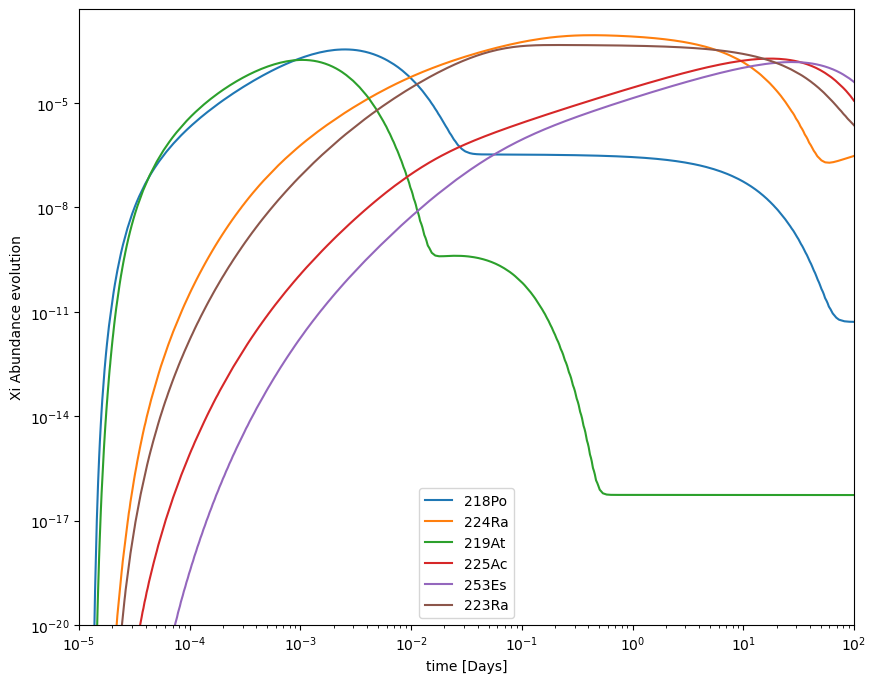

In [35]:
'''Codigo para monitorear la abundnacia de un cierto nucleo'''
l=[[134,84,'218Po'],[136,88,'224Ra'],[134,85,'219At'],[136,89,'225Ac'],[154,99,'253Es'],[135,88,'223Ra']]
def monitoreo_nucleos_xi(L):
    fige, axe1 = plt.subplots(1,1,figsize=(10, 8))
    for i in range(len(L)):
        axe1.plot(t/(24*60*60),Xi_t(L[i][0],L[i][1]),label=L[i][2])
    axe1.set_ylabel(f'Xi Abundance evolution')
    axe1.set_xlabel("time [Days]")
    axe1.set_yscale("log")
    axe1.set_xscale("log")
    axe1.set_xlim((0.00001,100))
    axe1.set_ylim((1e-20,0.005))
    axe1.legend()    

monitoreo_nucleos_xi(l)

'''
n_graph=118
p_graph=76

fige, axe1 = plt.subplots(1,1,figsize=(10, 8))
caxe1=axe1.plot(t/(24*60*60),Xi_ts[np.searchsorted(ts,t)-1][:,find_i_n_z(n_graph,p_graph)][:,3],label="Sin interpolacion")#caso discreto
caxe2=axe1.plot(t/(24*60*60),Xi_t_i[:,find_i_n_z(n_graph,p_graph)],label="Interpolacion")#interpolacion
axe1.set_xscale("log")
axe1.set_ylabel(f'Xi Abundance of nulcei {n_graph,p_graph}')
axe1.set_xlabel("time [s]")
axe1.set_yscale("log")
#axe1.set_xlim((1,100))
#axe1.set_ylim((1E-10,1E-7))
axe1.legend()
axe1.set_title("Example of Xi(t) for n="+str(n_graph)+", z= "+str(p_graph))'
'''

In [6]:
'''Datos de decaimientos'''

datos=pd.read_csv('Datos_decaimientos_Beta_Alpha.csv')
Decay_modes=datos['decayModes']
Z=datos['z']
N=datos['n']
Name=datos['name']
Level_energy=datos['levelEnergy(MeV)']
Half_life=datos['halflife']
Half_life_unit=datos['halflifeUnit']

Mass_exces=datos['massExcess(keV)']
Q_beta=datos['betaMinus(keV)']
Q_alpha=datos['alpha(keV)']

def convertir_a_segundos(T,unit):
    R=0
    if unit!='s':
        if unit=='y':
            R=365*24*60*60*T
        elif unit=='m':
            R=60*T
        elif unit=='ms':
            R=T/1000
        elif unit=='ns':
            R=T/1000000000
        elif unit=='h':
            R=T*60*60
        elif unit =='d':
            R=T*60*60*24
        elif unit == 'us':
            R=T/1000000
        elif unit=='mev':
            R=(np.log(2)*6.582119E-22)/(T)
        elif unit=='ev':
            R=(np.log(2)*6.582119E-16)/(T)
        elif unit=='kev':
            R=(np.log(2)*6.582119E-19)/(T)
    else:
        R=T
    return float(R)

In [7]:
'''Calculo tasa de generacion de energia'''
E_alpha_aporte=[]
Name_alpha=[]
E_beta_aporte=[]
Name_beta=[]
Nuclei_beta=[]
Nuclei_alpha=[]
E_beta=np.zeros(10000)
E_alpha=np.zeros(10000)
XA=0
isomers_b=[]

for i in tqdm(range(len(Decay_modes))):
    l=Level_energy[i]
    
    deca=Decay_modes[i]
    w=deca.split(' ')
    if Level_energy[i]==0:

        if w[0]=='B-' and w[2]!='': #and Z[i]<111 and N[i]<226:
            p=float(w[2])/100
            lamb=np.log(2)/convertir_a_segundos(Half_life[i],Half_life_unit[i])
            d=p*(c**2)*Q_beta[i]*lamb/((Z[i]+N[i])*931494.103+Mass_exces[i])
            
            if d!=0 and Q_beta[i]>0:
                e=d*Xi_t(N[i],Z[i])*np.exp(-lamb*t)
                E_beta_aporte.append(e)
                Name_beta.append(Name[i])
                E_beta+=e
                Nuclei_beta.append([N[i],Z[i]])


        if w[0]=='A' and w[2]!='':# and Z[i]<111 and N[i]<226:
            p=float(w[2])/100
            lamb=np.log(2)/convertir_a_segundos(Half_life[i],Half_life_unit[i])
            d=p*(c**2)*Q_alpha[i]*lamb/((Z[i]+N[i])*931494.103+Mass_exces[i])
            if d!=0 and not np.isnan(d):
                e=d*Xi_t(N[i],Z[i])*np.exp(-lamb*t)
                E_alpha_aporte.append(e)
                Name_alpha.append(Name[i])
                E_alpha+=e
                Nuclei_alpha.append([N[i],Z[i]])
                if N[i]+Z[i]>=210:
                    XA+=Xi_t(N[i],Z[i])
                    
    
E_alpha_aporte=np.array(E_alpha_aporte)
E_beta_aporte=np.array(E_beta_aporte)     
E_alpha_aporte_n=(E_alpha_aporte)/E_alpha
E_beta_aporte_n=(E_beta_aporte)/E_beta

  0%|          | 0/3421 [00:00<?, ?it/s]

In [8]:
'''Calculations and Termalization'''
#Important Values
Mey=0.05
Vey=0.15#c


#time
t_dias=t*(1/(60*60*24))#s

#termalizations
tb=12.9*((Mey/0.01)**(2/3))*((Vey/0.2)**(-2))*24*60*60 #termalization beta particles
ty=0.3*np.sqrt(Mey/0.01)*(0.2/Vey)*24*60*60 ##termalization gamma particles
f_gamma=1-np.exp(-(ty/t)**2)
f_electrons=(1+t/tb)**(-1)
f_beta=0.2*f_electrons+0.5*f_gamma
f_alpha=(1+t/(3*tb))**(-1)

#termalization Barnes 2016
a_th=0.27
b_th=0.1
d_th=0.6
e_th=0.36*(np.exp(-a_th*t_dias)+np.log(1+2*b_th*t_dias**d_th)/(2*b_th*t_dias**d_th))

#termalization Metzger 2010
e_Metzger_th=0.75

#Termalization*Heating rate
E_alpha_efectivo=E_alpha*f_alpha
E_alpha_aporte_efectivo=E_alpha_aporte*f_alpha
E_beta_efectivo=E_beta*f_beta
E_beta_aporte_efectivo=E_beta_aporte*f_beta
E_alpha_erg=(10**4)*E_alpha_efectivo#erg/g*s
E_beta_erg=(10**4)*E_beta_efectivo#erg/g*s

#total Efective Heating
E_total_efectivo=E_beta_efectivo+E_alpha_efectivo
E_total_efectivo_erg=(10**4)*E_total_efectivo#erg/g*s



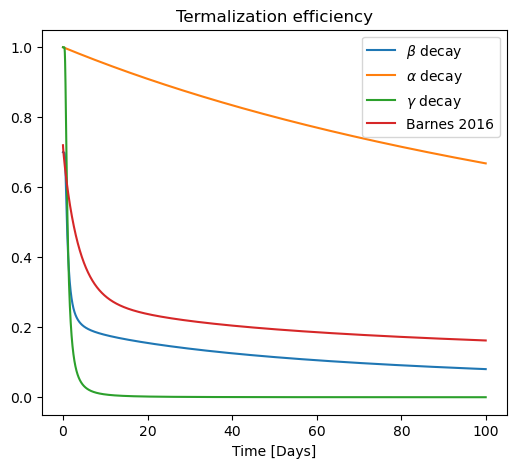

In [9]:
''' Termalization plot '''

plt.figure(figsize=(6,5))
plt.plot(t_dias,f_beta,label=r'$\beta$ decay')
plt.plot(t_dias,f_alpha,label=r'$\alpha$ decay')
plt.plot(t_dias,f_gamma,label=r'$\gamma$ decay')
plt.plot(t_dias,e_th,label='Barnes 2016')
plt.title('Termalization efficiency')
plt.xlabel('Time [Days]')
plt.legend()


In [10]:
''' Other Models for Heating Rate'''
#Metzger 2010
E_metzger=e_Metzger_th*(3*10**10)*(t_dias)**(-1.3)

#aproximation
E_korobkin=e_th*(4*10**18)*(0.5-(1/np.pi)*np.arctan((t-1.3)/0.11))**(1.3)

#Power Law Hotokezaka
E_hoto_e=(4*10**9)*(t_dias)**(-1.3)
E_hoto_g=(8*10**9)*(t_dias)**(-1.3)
E_hoto_a=(7*10**8)*(1/t_dias)*(XA/3e-2)
E_hoto_f=(2*10**9)*(1/t_dias)*(XA/2e-2)
E_Hoto=E_hoto_e+f_gamma*E_hoto_g+E_hoto_a+E_hoto_f

#power law Waxman 2018
e_wax=2E10
beta_wax=1.3
alpha_wax=3
kappa_wax=0.2
M_wax=0.05
v_wax=0.1
t_M=1.5*(1/np.sqrt(1+2*alpha_wax))*np.sqrt((kappa_wax/1)*(M_wax/0.01)*(0.1/v_wax))
E_waxman=e_wax*(t_dias/t_M)**(-beta_wax)

#termalization for waxman
f_vy=0.7
kappa_e=1
f_e=kappa_e*((3*M_wax)/(4*np.pi*v_wax**3*(c*t)**2))<1
f_e=np.zeros(len(t_dias))+1-1*f_e+f_e*kappa_e*((3*M_wax)/(4*np.pi*v_wax**3*(c*t)**2))
E_waxman_efectivo=(1-f_vy)*E_waxman*f_e

#XKN model
E_XKN=0.5*(10**10)*(t_dias)**(-1.3)+2e10*np.exp(-t_dias/1)


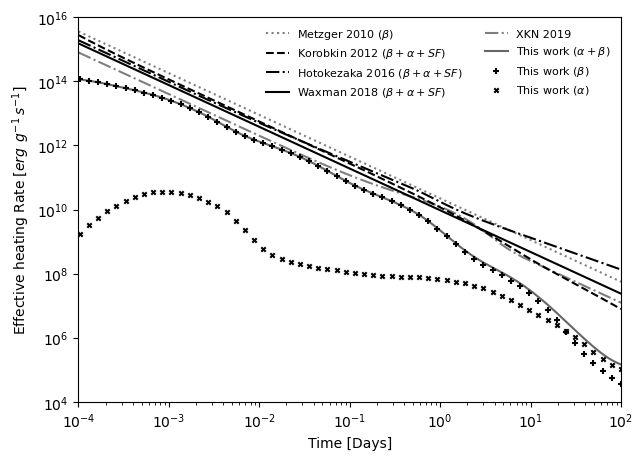

In [11]:
'''Figure 1. Our Heating rate compare to others models'''


fig1 ,ax1 = plt.subplots(1,1,figsize=(7,5))
ax1.plot(t_dias,E_metzger,label=r'Metzger 2010 ($\beta$)',linestyle=':',alpha=0.5,color='black')
ax1.plot(t_dias,E_korobkin,label=r'Korobkin 2012 ($\beta+\alpha+SF$)',linestyle='--',color='black')
ax1.plot(t_dias,E_Hoto,label=r'Hotokezaka 2016 ($\beta+\alpha+SF$)',linestyle='-.',color='black')
ax1.plot(t_dias,E_waxman,label=r'Waxman 2018 ($\beta+\alpha+SF$)',linestyle='-',color='black')
ax1.plot(t_dias,E_XKN,label=r'XKN 2019',linestyle='-.',alpha=0.5,color='black')  
ax1.plot(t_dias,E_total_efectivo_erg,label=r'This work ($\alpha+\beta$)',alpha=0.6,color='black')
#ax1.scatter(np.exp(np.linspace(np.log(1e-5),np.log(1e2),70)),E_total_efectivo_erg[np.searchsorted(t_dias,np.exp(np.linspace(np.log(1e-5),np.log(1e2),70)))-1],label=r'This work ($\beta+\alpha$)',marker='1',s=12,color='black',linewidths=1.5)
#ax1.plot(t_dias,E_beta_erg,alpha=0.3,color='black')
ax1.scatter(np.exp(np.linspace(np.log(1e-5),np.log(1e2),70)),E_beta_erg[np.searchsorted(t_dias,np.exp(np.linspace(np.log(1e-5),np.log(1e2),70)))-1],label=r'This work ($\beta$)',marker='+',s=15,color='black',linewidths=1.5)
#ax1.plot(t_dias,E_alpha_erg,alpha=0.3,color='black',linestyle='--')
ax1.scatter(np.exp(np.linspace(np.log(1e-5),np.log(1e2),70)),E_alpha_erg[np.searchsorted(t_dias,np.exp(np.linspace(np.log(1e-5),np.log(1e2),70)))-1],label=r'This work ($\alpha$)',marker='x',s=10,color='black')



ax1.legend()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(left=1e-4,right=100)
ax1.set_ylim(bottom=1e4,top=1e16)
ax1.set_xlabel('Time [Days]')
ax1.set_ylabel(r'Effective heating Rate [$erg\:\:g^{-1}\:s^{-1}$]')
plt.legend(loc="upper right", ncol=2,frameon=False,fontsize=8)


In [12]:
print(E_beta_erg[np.searchsorted(t_dias,np.exp(np.linspace(np.log(1e-5),np.log(1e2),10)))])

IndexError: index 10000 is out of bounds for axis 0 with size 10000

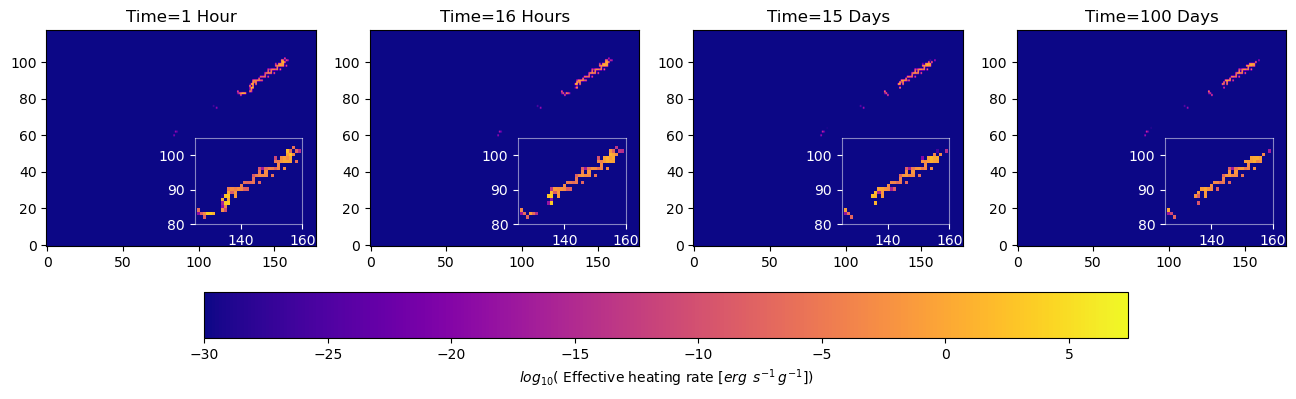

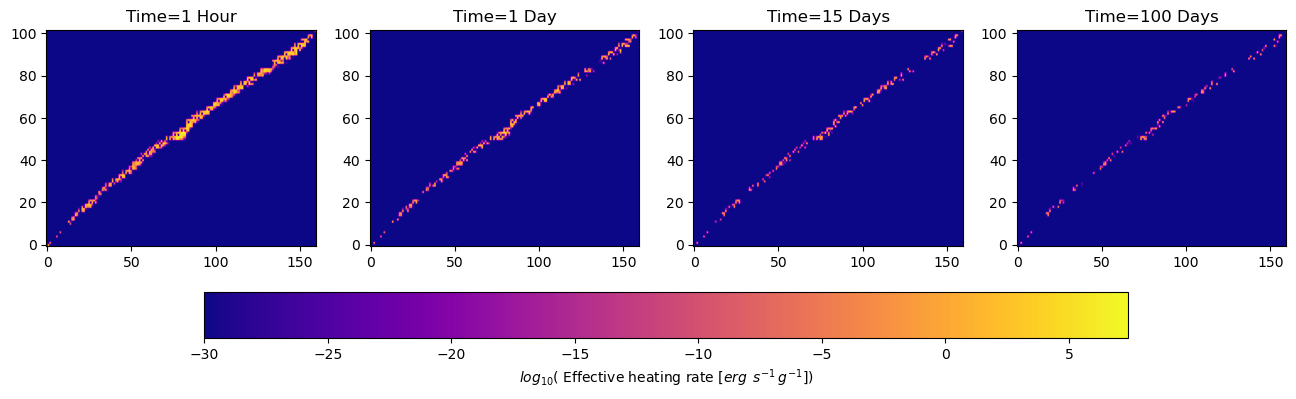

In [ ]:
'''Figure 3. nucharts of heating rate'''

neutrons = [np.array(Nuclei_alpha)[:,0],np.array(Nuclei_beta)[:,0]]
protons = [np.array(Nuclei_alpha)[:,1],np.array(Nuclei_beta)[:,1]] 
max_neutronsA = neutrons[0].max()
max_protonsA = protons[0].max()
max_neutronsB = neutrons[1].max()
max_protonsB = protons[1].max()


def Generar_grafica_epsion_nuchart(tiempo_abundnacia,unit,Decaimiento,x_start,x_end,y_start,y_end):
    epsilon_per_nuclei = []
    if Decaimiento=='Alpha':
        if unit=='Days':
            heatmap_matrix = np.zeros((max_protonsA+ 1,max_neutronsA + 1))
            for i in range(len(Nuclei_alpha)):
                epsilon_per_nuclei.append(E_alpha_aporte[i][np.searchsorted(t/(60*60*24),tiempo_abundnacia,side='left')-1])
            for n, p, a in zip(neutrons[0], protons[0], epsilon_per_nuclei):
                heatmap_matrix[p, n] = a
        if unit=='Hours':
            heatmap_matrix = np.zeros((max_protonsA+ 1,max_neutronsA + 1))
            for i in range(len(Nuclei_alpha)):
                epsilon_per_nuclei.append(E_alpha_aporte[i][np.searchsorted(t/(60*60),tiempo_abundnacia,side='left')-1])
            for n, p, a in zip(neutrons[0], protons[0], epsilon_per_nuclei):
                heatmap_matrix[p, n] = a
    else:
        if unit=='Days':
            heatmap_matrix = np.zeros((max_protonsB+ 1,max_neutronsB + 1))
            for i in range(len(Nuclei_beta)):
                epsilon_per_nuclei.append(E_beta_aporte[i][np.searchsorted(t/(60*60*24),tiempo_abundnacia,side='left')-1])
            for n, p, a in zip(neutrons[1], protons[1], epsilon_per_nuclei):
                heatmap_matrix[p, n] = a
        if unit=='Hours':
            heatmap_matrix = np.zeros((max_protonsB+ 1,max_neutronsB + 1))
            for i in range(len(Nuclei_beta)):
                epsilon_per_nuclei.append(E_beta_aporte[i][np.searchsorted(t/(60*60),tiempo_abundnacia,side='left')-1])
            for n, p, a in zip(neutrons[1], protons[1], epsilon_per_nuclei):
                heatmap_matrix[p, n] = a
    log_heatmap_matrix = np.log10(heatmap_matrix+1e-30)
    subset=log_heatmap_matrix[y_start:y_end+1,x_start:x_end+1]
    

    return log_heatmap_matrix,subset,tiempo_abundnacia,unit,x_start,x_end,y_start,y_end,heatmap_matrix
#log_heatmap_matrix , subset, tiempo_abundancia, unidad,x_start,x_end,y_start,y_end = Generar_grafica_epsion_nuchart(1,'Days','Alpha',0,max_neutronsA,0,max_protonsA)#,125,160,80,105)

fig2a, axsa = plt.subplots(1,4, figsize=(16,4))
t_matrix=[(1,'Hours'),(16,'Hours'),(15,'Days'),(100,'Days')]
for i, ax in enumerate(axsa.flat):
    log_heatmap_matrix ,subset, tiempo_abundancia, unidad,x_start,x_end,y_start,y_end,heat_matri1 = Generar_grafica_epsion_nuchart(t_matrix[i][0],t_matrix[i][1],'Alpha',125,160,80,105)
    cax = ax.imshow(log_heatmap_matrix, origin='lower', cmap='plasma', aspect='auto',vmin=-30,vmax=np.log10(5.5**10),extent=[-0.5, max_neutronsA+0.5,0-0.5, max_protonsA+0.5])#
    axins=ax.inset_axes([0.55, 0.1, 0.4, 0.4],xlim=(125,160),ylim=(80,105))
    axins.imshow(subset, origin='lower', cmap='plasma', aspect='auto',vmin=-30,vmax=np.log10(5.5**10),extent=[x_start-0.5, x_end+0.5,y_start-0.5, y_end+0.5])
    for spine in axins.spines.values():
        spine.set_edgecolor('white')
        spine.set_alpha(0.5)
    axins.tick_params(axis='both', colors='white')#,alpha=0.5)
    #ax.indicate_inset_zoom(axins,edgecolor="1")    #ax.set_xlabel("Number of Neutrons")
    #ax.set_ylabel("Number of Protons")
    if unidad=='Days':
        if t_matrix[i][0]==1:
            ax.set_title(f'Time={tiempo_abundancia} Day')
        else:
            ax.set_title(f'Time={tiempo_abundancia} Days')
    if unidad=='Hours':
        if t_matrix[i][0]==1:
            ax.set_title(f'Time={tiempo_abundancia} Hour')
        else:
            ax.set_title(f'Time={tiempo_abundancia} Hours')

fig2b, axsb = plt.subplots(1,4, figsize=(16,4))
t_matrix=[(1,'Hours'),(1,'Days'),(15,'Days'),(100,'Days')]
for i, ax in enumerate(axsb.flat):
    log_heatmap_matrix ,subset, tiempo_abundancia, unidad,x_start,x_end,y_start,y_end,heat_matri  = Generar_grafica_epsion_nuchart(t_matrix[i][0],t_matrix[i][1],'',0,max_neutronsB,0,max_protonsB)
    cax = ax.imshow(subset, origin='lower', cmap='plasma', aspect='auto',vmin=-30,vmax=np.log10(5.5**10),extent=[x_start-0.5, x_end+0.5,y_start-0.5, y_end+0.5])#
    #ax.set_xlabel("Number of Neutrons")
    #ax.set_ylabel("Number of Protons")
  
    
    if unidad=='Days':
        if t_matrix[i][0]==1:
            ax.set_title(f'Time={tiempo_abundancia} Day')
        else:
            ax.set_title(f'Time={tiempo_abundancia} Days')
    if unidad=='Hours':
        if t_matrix[i][0]==1:
            ax.set_title(f'Time={tiempo_abundancia} Hour')
        else:
            ax.set_title(f'Time={tiempo_abundancia} Hours')
colorbar = fig2a.colorbar(cax, ax=axsa.ravel().tolist(), orientation='horizontal')
colorbar.set_label(r'$log_{10}$( Effective heating rate $[erg\:\:s^{-1}\:g^{-1}]$)')
colorbar = fig2b.colorbar(cax, ax=axsb.ravel().tolist(), orientation='horizontal')
colorbar.set_label(r'$log_{10}$( Effective heating rate $[erg\:\:s^{-1}\:g^{-1}]$)')


'\nFigure 1. article, plot Heating rates for models\nfig, (ax2, ax3)=plt.subplots(1,2, figsize=(12,4))\n\nax1.plot(t_dias,E_alpha_efectivo*10**4,color=\'green\',linestyle=\'--\',label=r\'$f_{\x07lpha}\\dot\\epsilon_\x07lpha$\')\nax1.plot(t_dias,E_beta_efectivo*10**4,color=\'red\',linestyle=\'--\',label=r\'$f_{\x08eta}\\dot\\epsilon_\x08eta$\')\nax1.set_xscale("log")\nax1.set_xlim(left=0.0001,right=100)\nax1.set_ylim(bottom=1)\nax1.set_title(\'\')\nax1.set_xlabel("time [days]")\nax1.set_yscale("log")\nax1.legend()\n\nax2.plot(t_dias,E_alpha_efectivo*10**4,color=\'green\',linestyle=\'--\',label=r\'$f_{\x07lpha}\\dot\\epsilon_\x07lpha$\')\nax2.plot(t_dias,E_beta_efectivo*10**4,color=\'red\',linestyle=\'--\',label=r\'$f_{\x08eta}\\dot\\epsilon_\x08eta$\')\nax2.plot(t_dias,E_hoto_e,color=\'red\',label=r\'$\x08eta$ decay power law\')\nax2.plot(t_dias,E_hoto_a,color=\'green\',label=r\'$\x07lpha$ decay power law\')\nax2.set_xscale("log")\nax2.set_xlim(left=1,right=100)\nax2.set_ylim(bottom=3,t

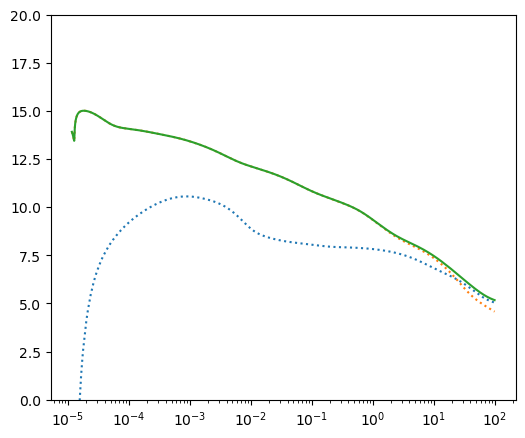

In [ ]:
'''Test figure for the heating rate'''
plt.figure(figsize=(6,5))
plt.plot(t_dias,np.log10(E_alpha_erg),linestyle=':')#,color='black')
plt.plot(t_dias,np.log10(E_beta_erg),linestyle=':')#,color='black')
plt.plot(t_dias,np.log10(E_total_efectivo_erg),linestyle='-')#,color='black')
#plt.yscale('log')
plt.xscale('log')
#plt.xlim((10**-2.5,10**2))
plt.ylim((0,20)) 
'''
Figure 1. article, plot Heating rates for models
fig, (ax2, ax3)=plt.subplots(1,2, figsize=(12,4))

ax1.plot(t_dias,E_alpha_efectivo*10**4,color='green',linestyle='--',label=r'$f_{\alpha}\dot\epsilon_\alpha$')
ax1.plot(t_dias,E_beta_efectivo*10**4,color='red',linestyle='--',label=r'$f_{\beta}\dot\epsilon_\beta$')
ax1.set_xscale("log")
ax1.set_xlim(left=0.0001,right=100)
ax1.set_ylim(bottom=1)
ax1.set_title('')
ax1.set_xlabel("time [days]")
ax1.set_yscale("log")
ax1.legend()

ax2.plot(t_dias,E_alpha_efectivo*10**4,color='green',linestyle='--',label=r'$f_{\alpha}\dot\epsilon_\alpha$')
ax2.plot(t_dias,E_beta_efectivo*10**4,color='red',linestyle='--',label=r'$f_{\beta}\dot\epsilon_\beta$')
ax2.plot(t_dias,E_hoto_e,color='red',label=r'$\beta$ decay power law')
ax2.plot(t_dias,E_hoto_a,color='green',label=r'$\alpha$ decay power law')
ax2.set_xscale("log")
ax2.set_xlim(left=1,right=100)
ax2.set_ylim(bottom=3,top=10**11)
ax2.set_xlabel("time [days]")
ax2.set_yscale("log")
ax2.legend()
ax3.plot(t_dias,E_alpha_efectivo*10**4,linestyle='--',color='green',label=r'$f_{\alpha}\dot\epsilon_\alpha$')
ax3.plot(t_dias,E_beta_efectivo*10**4,linestyle='--',color='red',label=r'$f_{\beta}\dot\epsilon_\beta$')
#ax3.plot(t_dias,E_korobkin,label=r"fit $\dot\epsilon$ (Korobkin,2012)")
ax3.set_xscale("log")
ax3.set_xlim(left=1,right=100)
ax3.set_ylim(bottom=3,top=10**11)
ax3.set_xlabel("time [days]")
ax3.set_yscale("log")
ax3.legend()
'''

In [ ]:
'''Find relevant nuclei'''
H=np.searchsorted(t/(60*60*24),[1,100])
#print(H)
#H=[0,-1]
E_alpha_aporte_norm=E_alpha_aporte/E_alpha
E_beta_aporte_norm=E_beta_aporte/E_beta
picos_alpha=np.zeros(len(E_alpha_aporte_norm))
for i in range(len(E_alpha_aporte_norm)):
    picos_alpha[i]=max(E_alpha_aporte_norm[i][H[0]:H[1]])
    
mejores_alpha=(-picos_alpha).argsort()
    

picos_beta=np.zeros(len(E_beta_aporte_norm))
for i in range(len(E_beta_aporte_norm)):
    picos_beta[i]=max(E_beta_aporte_norm[i][H[0]:H[1]])
    
Mejores_beta=(-picos_beta).argsort()


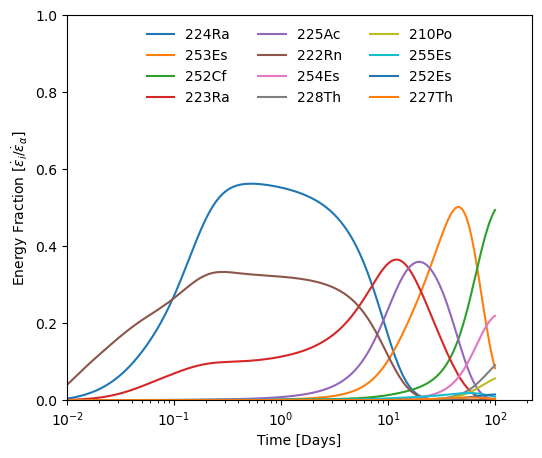

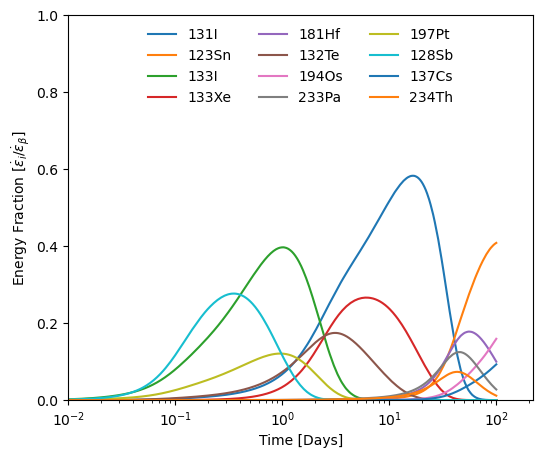

In [ ]:
'''Figure not. article relevant nuclei'''
def graficas_masimportantes(top:int,topa:int,decay):
    plt.figure(figsize=(6,5))
    if decay=='Beta':
        for i in range(top):
            plt.plot(t_dias,E_beta_aporte_norm[Mejores_beta[i]],label=Name_beta[Mejores_beta[i]])
        plt.ylabel(r'Energy Fraction $[\dot\epsilon_{i}/\dot\epsilon_{\beta}]$')
        plt.xlabel('Time [Days]')
        plt.xscale('log')
        plt.legend(loc="upper center", ncol=3,frameon=False)
        plt.ylim((0,1))
        plt.xlim(left=0.01)
    else:
        for i in range(topa):
            plt.plot(t_dias,E_alpha_aporte_norm[mejores_alpha[i]],label=Name_alpha[mejores_alpha[i]])
        plt.ylabel(r'Energy Fraction $[\dot\epsilon_{i}/\dot\epsilon_{\alpha}]$')
        plt.xlabel('Time [Days]')
        plt.xscale('log')
        plt.xlim(left=0.01)
        plt.ylim((0,1))
        plt.legend(loc="upper center", ncol=3,frameon=False)

        
    
   

graficas_masimportantes(12,12,'Alpha')
graficas_masimportantes(12,12,'Beta')

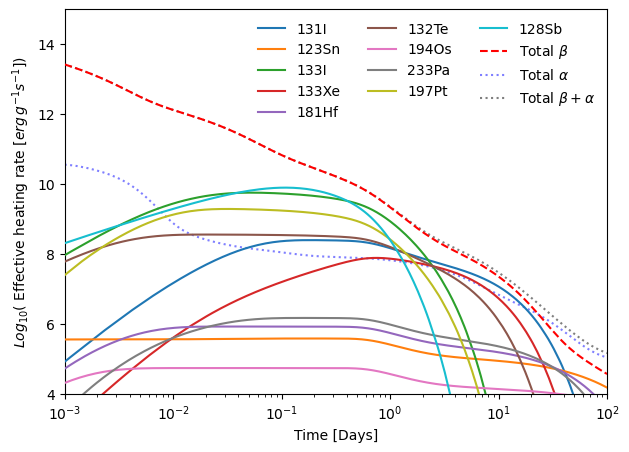

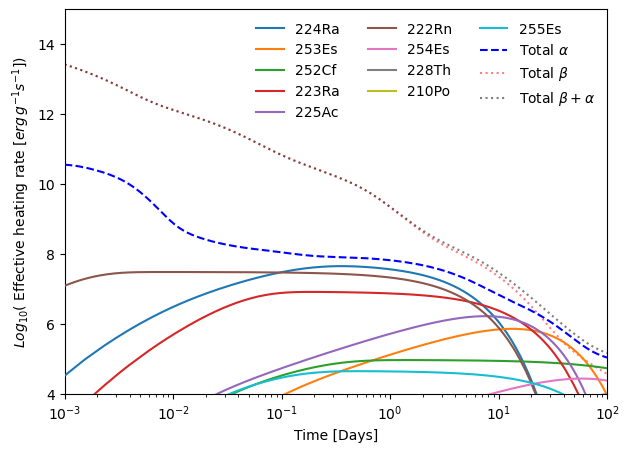

In [ ]:
'''Plots Heating Rate for relevant nuclei'''
def Heating_rate_mas_importantes(top:int,decay):
    plt.figure(figsize=(7,5))
    
    if decay=='Beta':
        for i in range(top):
            H=E_beta_aporte_efectivo[Mejores_beta[i]]+1e-34
            H=np.log10(H)+4
            plt.plot(t_dias,H,label=Name_beta[Mejores_beta[i]],linestyle='-',zorder=3,linewidth=1.5)
        plt.plot(t_dias,np.log10(E_beta_efectivo)+4,label=r'Total $\beta$',linestyle='--',color='red',zorder=3,linewidth=1.5)
        plt.plot(t_dias,np.log10(E_alpha_efectivo)+4,label=r'Total $\alpha$',linestyle=':',alpha=0.5,color='blue',zorder=1)
        
    elif decay=='Alpha':
        for i in range(top):
            H=E_alpha_aporte_efectivo[mejores_alpha[i]]+1e-34
            H=np.log10(H)+4
            plt.plot(t_dias,H,label=Name_alpha[mejores_alpha[i]],linestyle='-',zorder=3,linewidth=1.5)
        plt.plot(t_dias,np.log10(E_alpha_efectivo)+4,label=r'Total $\alpha$',linestyle='--',color='blue',zorder=3,linewidth=1.5)
        plt.plot(t_dias,np.log10(E_beta_efectivo)+4,label=r'Total $\beta$',linestyle=':',alpha=0.5,color='red',zorder=1)
        

    
    plt.plot(t_dias,np.log10(E_total_efectivo)+4,label=r'Total $\beta+\alpha$',linestyle=':',alpha=0.5,color='black',zorder=1)
    plt.legend(loc="upper right", ncol=3,frameon=False)
    #plt.ylim((35,42))
    #plt.xlim(left=0.01)
    plt.xscale('log')
    plt.ylabel(r'$Log_{10}$( Effective heating rate$\,\,[erg\, g^{-1} s^{-1}]$)')
    plt.xlabel('Time [Days]')
    plt.xlim((1e-3,10**2))
    plt.ylim((4,15))    
Heating_rate_mas_importantes(10,'Beta')
Heating_rate_mas_importantes(10,'Alpha')



The differential equation for $t<t_C$ is:
\begin{equation}
    \frac{dU}{dt}=\left(\frac{3M}{4\pi v^3}\right)\frac{\dot\epsilon(t)}{t^3}-\left(\frac{4}{t}+\frac{\pi v c t}{kM}\right)U
\end{equation}
change t to $\tau=\frac{t}{t_c}$
\begin{equation}
    \frac{dU}{d\tau}=\left(\frac{3M}{4\pi v^3}\right)\frac{\dot\epsilon(\tau t_c)}{{t_c}^2\tau^3}-\left(\frac{4}{\tau}+\frac{3c}{4v}\tau \right)U
\end{equation}
change U to $\textit{\~{U}}=\left( \frac{4 \pi v^3 t_c^2}{3M} \right)U$
\begin{equation}
    \frac{d\textit{\~{U}}}{d\tau}=\frac{\dot\epsilon(\tau t_c)}{\tau^3}-\left(\frac{4}{\tau}+\frac{3c}{4v}\tau \right)\textit{\~{U}}
\end{equation}
The differential equation for $t>t_c$ is:
\begin{equation}
    \frac{dU}{dt}=\left(\frac{3M}{4\pi v^3}\right)\frac{\dot\epsilon(t)}{t^3}-\left(4+\frac{3c}{4v}\right)\frac{U}{t}
\end{equation}
change t to $\tau=\frac{t}{t_c}$
\begin{equation}
    \frac{dU}{d\tau}=\left(\frac{3M}{4\pi v^3}\right)\frac{\epsilon(\tau t_c)}{{t_c}^2\tau^3}-\left(4+\frac{3c}{4v} \right)\frac{U}{\tau}
\end{equation}
change U to $\textit{\~{U}}=\left( \frac{4 \pi v^3 t_c^2}{3M} \right)U$
\begin{equation}
    \frac{d\textit{\~{U}}}{d\tau}=\frac{\dot\epsilon(\tau t_c)}{\tau^3}-\left(4+\frac{3c}{4v} \right)\frac{\textit{\~{U}}}{\tau}
\end{equation}
Luminosity for early times:
\begin{equation}
    L=\left(\frac{4\pi^2v^4c}{3kM}\right)t^4U(t)
\end{equation}
for late times:
\begin{equation}
    L= (\pi c v^2) t^2U(t)
\end{equation}

In [ ]:
'''New differential equation'''

def dudt_funtion_of_E_t(ta,u,b,tc,E__):
    if ta<=1:
        return (E__[np.searchsorted(t,ta*tc)])/(ta**3)-u*((4/ta) + 3*ta/(4*b))
    elif ta>1:
        return (E__[np.searchsorted(t,ta*tc)])/(ta**3)-(u/ta)*(4+3/(4*b))
 
def solucionar(U_0,tau_n,b,tc,n,E__):
    U_n=np.zeros(n)
    U_n[0]=U_0
    
    h=tau_n[1]-tau_n[0]
    for i in range(len(U_n)):
    
        k1=h*dudt_funtion_of_E_t(tau_n[i],U_n[i],b,tc,E__)
        k2=h*dudt_funtion_of_E_t(tau_n[i]+h/2,U_n[i]+k1/2,b,tc,E__)
        k3=h*dudt_funtion_of_E_t(tau_n[i]+h/2,U_n[i]+k2/2,b,tc,E__)
        k4=h*dudt_funtion_of_E_t(tau_n[i]+h,U_n[i]+k3,b,tc,E__)
        if i!=len(U_n)-1:
            U_n[i+1]=U_n[i]+(1/6)*(k1+2*k2+2*k3+k4)
    return U_n

def generar_graficas(M,k,b,U_0,tau_0,tau_f,n,E_):
    M=M*(1.989*10**30)#kg
    tc=np.sqrt(3*k*M/(4*np.pi*(b*c)**2))
    
    Tau_n=np.linspace(tau_0,tau_f,n)
    Uo=solucionar(U_0,Tau_n,b,tc,n,E_)
    te=tc*Tau_n
    tedias=te*(1/(60*60*24))
    U=((3*M)/(4*np.pi*((b*c)**3)*((tc)**(2))))*Uo
    L=np.zeros(len(U))
    i_tc=np.searchsorted(te,tc)
    L[:i_tc]=((np.pi*((b*c)**2)*c)*(te[:i_tc]**4)/(tc**2))*U[:i_tc]*10**7
    calpha=L[i_tc-1]/E_[np.searchsorted(t,tc)]
    #print(calpha,L[i_tc-1],E_[np.searchsorted(t,tc)])    
    #L[i_tc:]=((np.pi*c*(b*c)**2))*(te[i_tc:]**2)*U[i_tc:]*10**7
    
    spline_interp = interp1d(t, E_, kind='linear', fill_value="extrapolate")
    e_new=spline_interp(te)
    L[i_tc:]=calpha*e_new[i_tc:]
    T=(calpha,L[i_tc],E_[np.searchsorted(t,tc)])  
    #T=0#(c*U/(Sb*4))**(1/4)
    
    
    return [U,L,T,tedias]


In [ ]:
'''Luminosity for alpha and beta'''

p_Beta=generar_graficas(0.05,0.02,0.15,10**10,0.001,16,100000,E_beta_efectivo)
U_b,L_b,T_b,tedias_b=p_Beta[0],p_Beta[1],p_Beta[2],p_Beta[3]

p_Alpha=generar_graficas(0.05,0.02,0.15,10**10,0.001,16,100000,E_alpha_efectivo)
U_a,L_a,T_a,tedias_a=p_Alpha[0],p_Alpha[1],p_Alpha[2],p_Alpha[3]

In [ ]:
'''Luminosity for species of nuclei'''
def Luminocidad_mas_importantes(top:int,decay):
    r=[[],[],[]]
    if decay=='Beta':
        x__=np.zeros(100000)
        for i in tqdm(range(top)):
            U,L,T,t_dias_=generar_graficas(0.05,0.02,0.15,10**10,0.001,16,100000,E_beta_aporte_efectivo[Mejores_beta[i]])
            x__+=L
            L=np.log10(L+1e-30)
            r[0].append(t_dias_)
            r[1].append(L)
            r[2].append(Name_beta[Mejores_beta[i]])
            #plt.plot(t_dias_,L,label=Name_beta[Mejores_beta[i]],linestyle='-')
        #U,L,T,t_dias_=generar_graficas(0.05,0.02,0.15,10**10,0.001,16,100000,E_beta_efectivo)
        L=np.log10(x__+1e-30)
        r[0].append(t_dias_)
        r[1].append(L)
        r[2].append(r'Total $\beta$ decay')
        #plt.plot(t_dias_,np.log10(L),label='Total beta',linestyle=':')

    else:
        x__=np.zeros(100000)
        for i in tqdm(range(top)):
            U,L,T,t_dias_=generar_graficas(0.05,0.02,0.15,10**10,0.001,16,100000,E_alpha_aporte_efectivo[mejores_alpha[i]])
            x__+=L
            L=np.log10(L+1e-30)
            r[0].append(t_dias_)
            r[1].append(L)
            r[2].append(Name_alpha[mejores_alpha[i]])
            #plt.plot(t_dias_,L,label=Name_alpha[mejores_alpha[i]],linestyle='-')
        
        #U,L,T,t_dias_=generar_graficas(0.05,0.02,0.15,10**10,0.001,16,100000,E_alpha_efectivo)
        L=np.log10(x__+1e-30)
        r[0].append(t_dias_)
        r[1].append(L)
        r[2].append(r'Total $\alpha$ decay')
        #plt.plot(t_dias_,np.log10(L),label='Total alpha',linestyle=':')
    return r   
    


In [ ]:
r1=Luminocidad_mas_importantes(40,'Beta')
r2=Luminocidad_mas_importantes(40,'Alpha')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

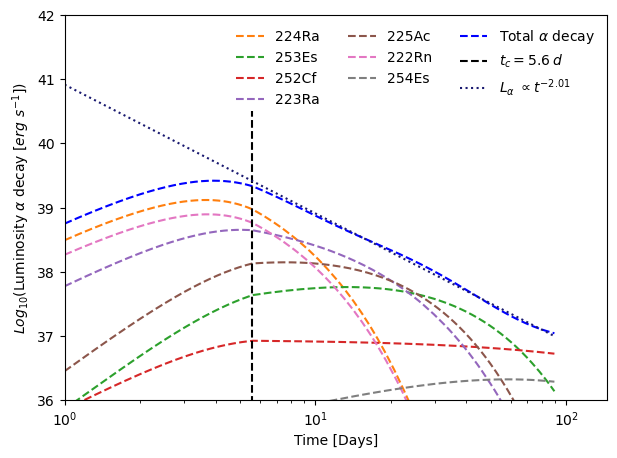

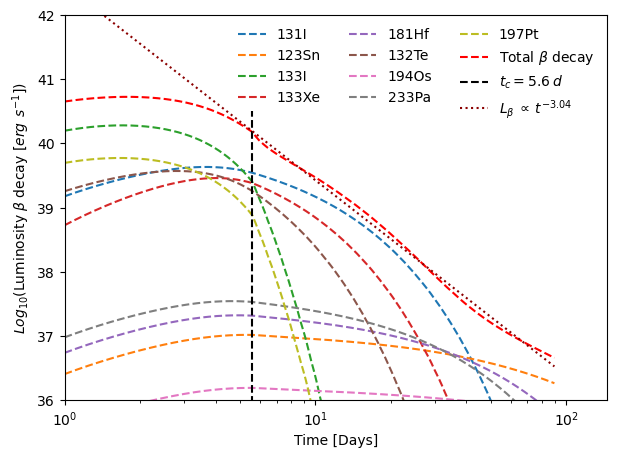

In [ ]:
'''Figure 4. Luminosity for relevant nuclei'''

'''Delimitation of tc'''
barra=np.linspace(35,40.5,100)
k=0.02
M=0.05*(1.989*10**30)
b=0.15
tc=np.sqrt(3*k*M/(4*np.pi*(b*c)**2))
ubi=np.zeros(len(barra))+tc/(60*60*24)
indice_tc=np.searchsorted(tedias_b,tc/(60*60*24))

'''fit funtion'''
def lineal(x,a,b):
    return a*x+b

'''Fits for total luminosity'''
#alpha
popta, pcova = curve_fit(lineal,np.log10(tedias_a[indice_tc:]),np.log10(L_a[indice_tc:]),p0=[-1,30])
popta_suma,pcova_suma=curve_fit(lineal,np.log10(tedias_a[indice_tc:]),r2[1][-1][indice_tc:],p0=[-1,30])
#beta
poptb, pcovb = curve_fit(lineal,np.log10(tedias_b[indice_tc:]),np.log10(L_b[indice_tc:]),p0=[-1,30])
poptb_suma,pcovb_suma=curve_fit(lineal,np.log10(tedias_b[indice_tc:]),r1[1][-1][indice_tc:],p0=[-1,30])
#total
poptt, pcovt = curve_fit(lineal,np.log10(tedias_b[indice_tc:]),np.log10(L_b[indice_tc:]+L_a[indice_tc:]),p0=[-1,30])
poptt_suma, pcovt_suma= curve_fit(lineal,np.log10(tedias_b[indice_tc:]),np.log10(10**(r1[1][-1][indice_tc:])+10**(r2[1][-1][indice_tc:])),p0=[-1,30])

'''Figure alpha decay'''

plt.figure(figsize=(7,5))
plt.plot(tedias_a[indice_tc])

for i in range(len(r2[0])):
    if i==len(r2[0])-1:
        plt.plot(r2[0][i],r2[1][i],label=r2[2][i],linestyle='--',color='blue')
    elif i<=6:
        plt.plot(r2[0][i],r2[1][i],label=r2[2][i],linestyle='--')

plt.plot(ubi,barra,linestyle='--',color='black',label=r'$t_c=5.6\:d$')
#plt.plot(tedias_a,lineal(np.log10(tedias_a), *popta),label='Total alpha fit',linestyle=':',color='midnightblue')
#plt.plot(tedias_a,np.log10(L_a+1e-30),label='Total alpha original')
plt.plot(tedias_a,lineal(np.log10(tedias_a), *popta_suma),label=r'$L_{\alpha}$ $\propto t^{-2.01}$', linestyle=':',color='midnightblue')
'''estetics'''
plt.xscale('log')
plt.ylim((36,42))
plt.xlim(left=1)
plt.ylabel(r'$Log_{10}$(Luminosity $\alpha$ decay $[erg \:\:s^{-1}])$')
plt.xlabel('Time [Days]')
plt.legend(loc="upper right", ncol=3,frameon=False)


'''Figure beta decay'''

plt.figure(figsize=(7,5))

for i in range(len(r1[0])):
    if i==len(r1[0])-1:
        plt.plot(r1[0][i],r1[1][i],label=r1[2][i],linestyle='--',color='red')
    elif i<=8:
        plt.plot(r1[0][i],r1[1][i],label=r1[2][i],linestyle='--')

plt.plot(ubi,barra,linestyle='--',color='black',label=r'$t_c=5.6\:d$')
#plt.plot(tedias_b,lineal(np.log10(tedias_b), *poptb),label='Total Beta fit',linestyle=':',color='darkred')
plt.plot(tedias_b,lineal(np.log10(tedias_b),*poptb_suma),label=r'$L_{\beta} \: \propto\:t^{-3.04} $',linestyle=':',color='darkred')


plt.xscale('log')
plt.ylim(bottom=36,top=42)
plt.xlim(left=1)
plt.ylabel(r'$Log_{10}$(Luminosity $\beta$ decay $[erg \:\:s^{-1}])$')
plt.xlabel('Time [Days]')
plt.legend(loc="upper right", ncol=3,frameon=False)


1.1251460582378092

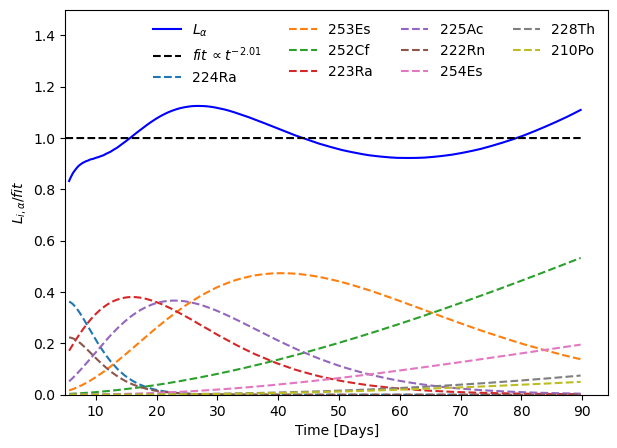

In [ ]:
'''Residuals alpha'''

#Alpha
lineal_a=lineal(np.log10(tedias_a[indice_tc:]), *popta)
lineal_a_suma=lineal(np.log10(tedias_a[indice_tc:]),*popta_suma)
Residual_alpha=10**(np.log10(L_a[indice_tc:])-lineal_a)
Residual_alpha_suma=10**(r2[1][-1][indice_tc:]-lineal_a_suma)
#Beta
lineal_b=lineal(np.log10(tedias_b[indice_tc:]), *poptb)
Residual_beta=10**(np.log10(L_b[indice_tc:])-lineal_b)
lineal_b_suma=lineal(np.log10(tedias_b[indice_tc:]),*poptb_suma)
Residual_beta_suma=10**(r1[1][-1][indice_tc:]-lineal_b_suma)

#total
lineal_t_suma=lineal(np.log10(tedias_b[indice_tc:]), *poptt_suma)
Residual_total_suma=10**(np.log10(10**(r2[1][-1][indice_tc:])+10**(r1[1][-1][indice_tc:]))-lineal_t_suma) 


'''Figure 5. Fluctuations of luminosity'''

'''ALpha fluctuations'''
plt.figure(figsize=(7,5))
#plt.plot(tedias_a[indice_tc:],Residual_alpha,label='Total alpha residuals',color='blue')
plt.plot(tedias_a[indice_tc:],Residual_alpha_suma,label=r'$L_{\alpha}$', color='blue')
#plt.plot(tedias_a[indice_tc:],10**(np.log10(10**(r2[1][-1][indice_tc:])-10**(r2[1][3][indice_tc:]))-lineal_a_suma),label='alpha-'+str(r2[2][3]))

'''Delimitations'''
#plt.plot(np.zeros(10)+tedias_a[indice_tc:][np.argmax(Residual_alpha[:50000])],np.linspace(0.6,1.5,1000),label='max alpha',linestyle='--',color='blue')
plt.plot(tedias_a,np.zeros(len(tedias_a))+1,linestyle='--',color='black',label=r'$fit\: \propto t^{-2.01}$')

'''Nucleoas imporantes luminosity'''
tri=np.zeros(len(r2[1][0][indice_tc:]))
for i in range(len(r2[0])):
    if i!=len(r2[0])-1:
        tri+=10**(r2[1][i][indice_tc:]-lineal_a_suma)
        if i<=8:
           plt.plot(r2[0][i][indice_tc:],10**(r2[1][i][indice_tc:]-lineal_a_suma),label=r2[2][i],linestyle='--')
#plt.plot(r2[0][0][indice_tc:],tri,label='tri',linestyle=':')

'''estetics'''
plt.ylabel(r'$L_{i,\alpha}/fit$')
plt.xlabel('Time [Days]')
plt.ylim((0,1.5))
plt.xlim(left=5)
plt.legend(loc="upper right", ncol=4,frameon=False)


'''Ubications of fluctiations'''
xs=[]
for i in range(len(Residual_alpha_suma)):
    if i!=len(Residual_alpha_suma)-1:
        if Residual_alpha_suma[i]<1 and Residual_alpha_suma[i+1]>1:
            xs.append(tedias_a[indice_tc:][i])
        elif Residual_alpha_suma[i]>1 and Residual_alpha_suma[i+1]<1:
            xs.append(tedias_a[indice_tc:][i])
ys=np.argmax(Residual_alpha_suma)
tedias_a[indice_tc:][ys]
Residual_alpha_suma[ys]



In [ ]:
print(xs)

[15.613492540691782, 44.051175692825, 79.19179627858294]


15.303021810834464 1.2716143419312802


[8.591111234728304, 26.73480533217036, 66.63926726131702]

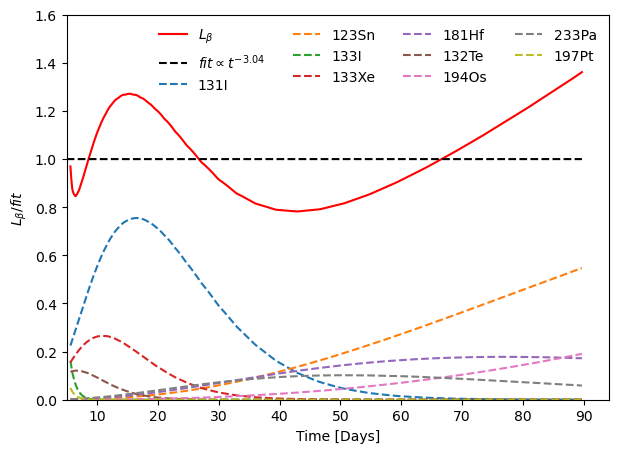

In [ ]:

'''Figure 5. Fluctuations of luminosity'''

'''Beta fluctuations'''
plt.figure(figsize=(7,5))
plt.plot(tedias_b[indice_tc:],Residual_beta_suma,label=r'$L_{\beta}$',color='red')
#plt.plot(tedias_b[indice_tc:],10**(np.log10(10**(r1[1][-1][indice_tc:])-10**(r1[1][0][indice_tc:]))-lineal_b_suma),label='beta-'+str(r1[2][0]))
'''Delimitations'''
#plt.plot(np.zeros(10)+tedias_b[indice_tc:][np.argmax(Residual_beta[:16000])],np.linspace(0.6,1.5,10),label='max beta',linestyle='--',color='red')
plt.plot(tedias_a,np.zeros(len(tedias_a))+1,linestyle='--',color='black',label=r'$fit \propto t^{-3.04}$')

'''Nucleoas imporantes luminosity'''
tri=np.zeros(len(r1[1][0][indice_tc:]))
for i in range(len(r1[0])):
    if i!=len(r1[1])-1:
        tri+=10**(r1[1][i][indice_tc:]-lineal_b_suma)
    if i<=8:
        plt.plot(r1[0][i][indice_tc:],10**(r1[1][i][indice_tc:]-lineal_b_suma),label=r1[2][i],linestyle='--')
#plt.plot(tedias_b[indice_tc:],tri-10**(r1[1][0][indice_tc:]-lineal_b_suma),label='tri')
'''estetics'''
plt.ylabel(r'$L_{\beta}/fit$')
plt.xlabel('Time [Days]')
plt.ylim((0,1.6))
plt.xlim(left=5)
plt.legend(loc="upper right", ncol=4,frameon=False)


'''Ubications of fluctiations'''
xs=[]
for i in range(len(Residual_beta_suma)):
    if i!=len(Residual_beta_suma)-1:
        if Residual_beta_suma[i]<1 and Residual_beta_suma[i+1]>1:
            xs.append(tedias_b[indice_tc:][i])
        elif Residual_beta_suma[i]>1 and Residual_beta_suma[i+1]<1:
            xs.append(tedias_b[indice_tc:][i])
ys=np.argmax(Residual_beta_suma[:50000])
print(tedias_b[indice_tc:][ys],Residual_beta_suma[:50000][ys])
xs

In [ ]:
poptt_suma

array([-2.57219235, 42.09897224])

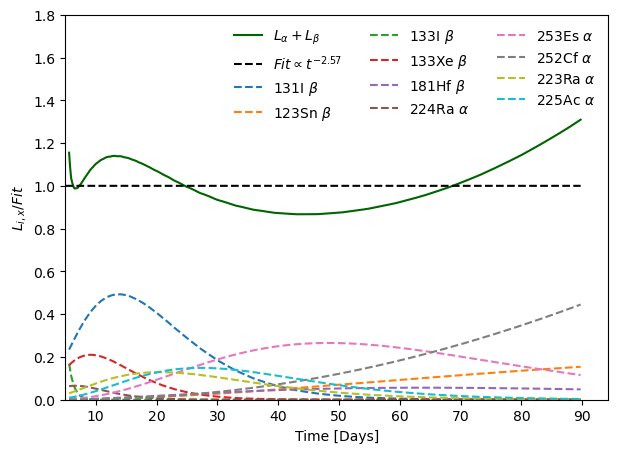

In [ ]:
'''Figure 5. Fluctuations of luminosity total'''

'''Beta fluctuations'''
plt.figure(figsize=(7,5))
plt.plot(tedias_b[indice_tc:],Residual_total_suma,label=r'$L_{\alpha}+L_{\beta}$ ',color='darkgreen')
#plt.plot(tedias_b[indice_tc:],10**(np.log10(10**(r1[1][-1][indice_tc:])+10**(r2[1][-1][indice_tc:])-10**(r2[1][1][indice_tc:]))-lineal_t_suma),label='total-'+str(r2[2][1]))

'''Delimitations'''
#plt.plot(np.zeros(10)+tedias_b[indice_tc:][np.argmax(Residual_beta[:16000])],np.linspace(0.6,1.5,10),label='max beta',linestyle='--',color='red')
plt.plot(tedias_a,np.zeros(len(tedias_a))+1,linestyle='--',color='black',label=r'$Fit \propto t^{-2.57}$')

'''Nucleoas imporantes luminosity'''
#tri=np.zeros(len(r1[1][0][indice_tc:]))
for i in range(len(r1[0])):
#   if i!=len(r1[1])-1:
#        tri+=10**(r1[1][i][indice_tc:]-lineal_b_suma)
    if i<=4:
        plt.plot(r1[0][i][indice_tc:],10**(r1[1][i][indice_tc:]-lineal_t_suma),label=r1[2][i]+r' $\beta$',linestyle='--')
for i in range(len(r2[0])):
    if i<=4:
        plt.plot(r2[0][i][indice_tc:],10**(r2[1][i][indice_tc:]-lineal_t_suma),label=r2[2][i]+r' $\alpha$',linestyle='--')
#plt.plot(tedias_b[indice_tc:],tri-10**(r1[1][0][indice_tc:]-lineal_b_suma),label='tri')
'''estetics'''
plt.ylabel(r'$L_{i,x}/Fit$')
plt.xlabel('Time [Days]')
plt.ylim((0,1.8))
plt.xlim(left=5)
plt.legend(loc="upper right", ncol=3,frameon=False)


'''Ubications of fluctiations'''
xs=[]
for i in range(len(Residual_beta)):
    if i!=len(Residual_beta)-1:
        if Residual_beta[i]<1 and Residual_beta[i+1]>1:
            xs.append(tedias_b[indice_tc:][i])
        elif Residual_beta[i]>1 and Residual_beta[i+1]<1:
            xs.append(tedias_b[indice_tc:][i])


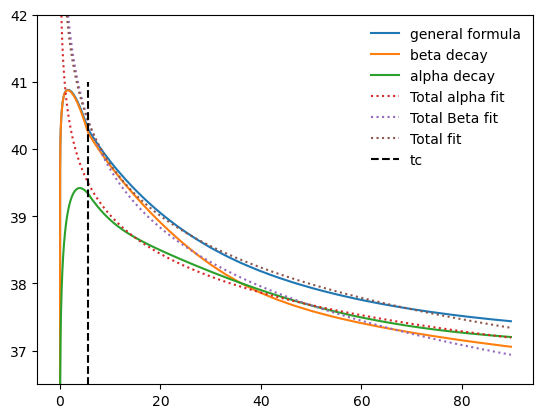

In [ ]:

fig7 , ax7= plt.subplots(1,1,)
barra=np.linspace(36,41,100)
k=0.02
M=0.05*(1.989*10**30)
b=0.15

ubi=np.zeros(len(barra))+tc/(60*60*24)
ax7.plot(tedias_b,np.log10(L_a+L_b),label="general formula")
ax7.plot(tedias_b,np.log10(L_b),label="beta decay")
ax7.plot(tedias_a,np.log10(L_a),label="alpha decay")
ax7.plot(tedias_a,lineal(np.log10(tedias_b), *popta),label='Total alpha fit',linestyle=':')
ax7.plot(tedias_b,lineal(np.log10(tedias_b), *poptb),label='Total Beta fit',linestyle=':')
ax7.plot(tedias_b,lineal(np.log10(tedias_b), *poptt),label='Total fit',linestyle=':')

ax7.plot(ubi,barra,linestyle='--',label='tc',color='black')
ax7.set_ylim(bottom=36.5,top=42)
#ax7.set_xscale('log')
#ax7.set_xlim(left=1)
ax7.legend(frameon=False)
